# Data Labeling

**You can think of every labeling strategy as a result of different labelers following different labeling rules**. If data is labeled by people using different criteria this will have a negative impact on learning algorithm. It is desired to have consistent labeling across dataset.

This lab will touch on effect of labeling strategies from a slighlty different angle. You will explore how different strategies affect performance of a ML model by simulating process of having different labelers label data. This, by defining a set of rules and performing automatic labeling based on those rules.

**The main objective is to compare performance across labeling options to understand role that good labeling plays on performance of ML models**, these options are:
1. Randomly generated labels (performance lower bound)
2. Automatic generated labels based on three different label strategies
3. True labels (performance upper bound)

Working with text data, containing comments from 2015 top 5 most popular Youtube videos. Each comment has been labeled as `spam` or `not_spam` depending on its contents.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading dataset

The dataset consists of 5 CSV files, one for each video.

In [2]:
def load_labeled_spam_dataset():
    """Load labeled spam dataset."""
    # Path where csv files are located
    base_path = "./data/"
    # List of csv files with full path
    csv_files = [os.path.join(base_path, csv) for csv in os.listdir(base_path)]
    # List of dataframes for each file
    dfs = [pd.read_csv(filename) for filename in csv_files]
    # Concatenate dataframes into a single one
    df = pd.concat(dfs)
    # Rename columns
    df = df.rename(columns={"CONTENT": "text", "CLASS": "label"})
    # Set a seed for order of rows
    df = df.sample(frac=1, random_state=824)
    return df.reset_index()

# Save dataframe into df_labeled variable
df_labeled = load_labeled_spam_dataset()

In [3]:
# Take a look at first 5 rows
df_labeled.head()

,index,COMMENT_ID,AUTHOR,DATE,text,label
0,86,z135fnx4ntvdx1rzn04cih1ihmqtsrbzcno0k,Backup Plus,2014-11-03T17:39:07,Suscribe My Channel Please XD lol﻿,1
1,291,LneaDw26bFtxWo398a4IB63xJxVOTtPd1Xqz0vPfw9s,Ractive,NaN,hey guy if you can please SUBSCRIBE to my chan...,1
2,230,z12gf55w4pr0ibswj04cfzyb4my1zbnjsps0k,Andrea Incollingo,2015-04-21T14:52:10.879000,Check out this video on YouTube:﻿,1
3,235,z12ssnxafveqfp2jj04chjxgxsf5d1pqxio,Trong Tan Trung Tran,2015-04-18T14:27:02.046000,Check out this video on YouTube:﻿,1
4,326,z13qczlqnoqajv4rd04ci5arplmksbi5yq00k,Andrew Willigar,NaN,"<a rel=""nofollow"" class=""ot-hashtag"" href=""htt...",1


## Further inspection and preprocessing

### Checking for data imbalance

Value counts for each class:

1    1005
0     951
Name: label, dtype: int64



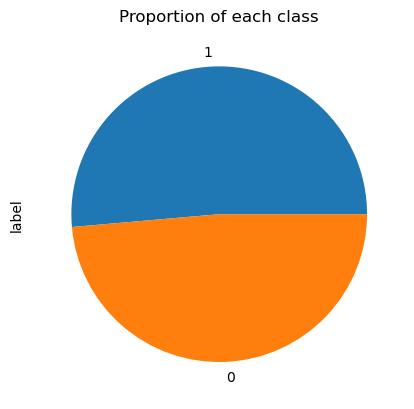

In [4]:
# Print actual value count
print(f"Value counts for each class:\n\n{df_labeled.label.value_counts()}\n")

# Display pie chart to visually check proportion
df_labeled.label.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

There is roughly same number of data points for each class so class imbalance is not an issue for this particular dataset.

### Cleaning dataset

In [5]:
# Drop unused columns
df_labeled = df_labeled.drop(['index', 'COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)

# Look at cleaned dataset
df_labeled.head()

,text,label
0,Suscribe My Channel Please XD lol﻿,1
1,hey guy if you can please SUBSCRIBE to my chan...,1
2,Check out this video on YouTube:﻿,1
3,Check out this video on YouTube:﻿,1
4,"<a rel=""nofollow"" class=""ot-hashtag"" href=""htt...",1


### Splitting dataset
When doing this split, remember to use stratification so proportion of classes is maintained within each split.

In [6]:
from sklearn.model_selection import train_test_split

# Save text into X variable
X = df_labeled.drop("label", axis=1)

# Save true labels into y variable
y = df_labeled["label"]

# Use 1/5 of data for testing later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print number of comments for each set
print(f"There are {X_train.shape[0]} comments for training.")
print(f"There are {X_test.shape[0]} comments for testing")

There are 1564 comments for training.
There are 392 comments for testing


Let's do a visual to check that stratification actually worked:

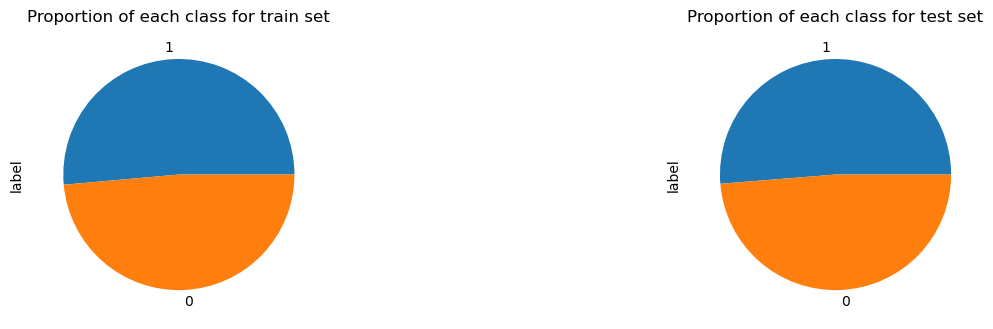

In [7]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

## Data Labeling 

### Establishing performance lower and upper bounds for reference

To properly compare different labeling strategies you need to establish a baseline for model accuracy, in this case you will establish both a lower and an upper bound to compare against. 



### Calculate accuracy of a labeling strategy

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) is a handy tool included in sklearn ecosystem to encode text based data.

For more information on how to work with text data using sklearn check out this [resource](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Allow unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 5))

Now that text encoding is defined, you need to select a model to make predictions. For simplicity you will use a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier. This model is well suited for text classification and is fairly quick to train.

Let's define a function which will handle model fitting and print out accuracy on test data:

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB


def calculate_accuracy(X_tr, y_tr, X_te=X_test, y_te=y_test, 
                       clf=MultinomialNB(), vectorizer=vectorizer):
    
    # Encode train text
    X_train_vect = vectorizer.fit_transform(X_tr.text.tolist())
    
    # Fit model
    clf.fit(X=X_train_vect, y=y_tr)
    
    # Vectorize test text
    X_test_vect = vectorizer.transform(X_te.text.tolist())
    
    # Make predictions for test set
    preds = clf.predict(X_test_vect)
    
    # Return accuracy score
    return accuracy_score(preds, y_te)


Now let's create a dictionary  to store accuracy of each labeling method:

In [10]:
# Empty dictionary
accs = dict()

### Random Labeling

Generating random labels is a natural way to establish a lower bound. You will expect that any successful alternative labeling model to outperform randomly generated labels. 

Now let's calculate accuracy for random labeling method

In [11]:
# Calculate random labels
rnd_labels = np.random.randint(0, 2, X_train.shape[0])

# Feed them alongside X_train to calculate_accuracy function
rnd_acc = calculate_accuracy(X_train, rnd_labels)

rnd_acc

0.6020408163265306

You will see a different accuracy everytime you run previous cell. This is due to fact that labeling is done randomly. Remember, this is a binary classification problem and both classes are balanced, so you can expect to see accuracies that revolve around 50%.

To further gain intuition let's look at average accuracy over 10 runs:

In [12]:
# Empty list to save accuracies
rnd_accs = []

for _ in range(10):
    # Add every accuracy to list
    rnd_accs.append(calculate_accuracy(X_train, np.random.randint(0, 2, X_train.shape[0])))

# Save result in accs dictionary
accs['random-labels'] = sum(rnd_accs)/len(rnd_accs)

# Print result
print(f"The random labelling method achieved and accuracy of {accs['random-labels']*100:.2f}%")

The random labelling method achieved and accuracy of 49.29%


Random labelling is completely disregarding information from solution space you are working on, and is just guessing correct label. You can't probably do worse than this (or maybe you can). For this reason, this method serves as reference for comparing other labeling methods


### Labeling with true values

Now let's look at other end of spectrum, this is using correct labels for data points. Let's retrain Multinomial Naive Bayes classifier with actual labels 

In [13]:
# Calculate accuracy when using true labels
true_acc = calculate_accuracy(X_train, y_train)

# Save result
accs['true-labels'] = true_acc

print(f"The true labelling method achieved and accuracy of {accs['true-labels']*100:.2f}%")

The true labelling method achieved and accuracy of 92.60%


Training with true labels produced a noticeable boost in accuracy. This is expected as classifier is now able to properly identify patterns in training data which were lacking with randomly generated labels. 

Achieving higher accuracy is possible by either fine-tunning model or even selecting a different one. For time being you will keep model as it is and use this accuracy as what we should strive for with automatic labeling algorithms you will see next.

## Automatic labeling - Trying out different labeling strategies

Let's suppose that for some reason you don't have access to true labels associated with each data point in this dataset. It is a natural idea to think that there are patterns in data that will provide clues of which are correct labels. This is of course very dependant on kind of data you are working with and to even hypothesize which patterns exist requires great domain knowledge.

The dataset used in this lab was used for this reason. It is reasonable for many people to come up with rules that might help identify a spam comment from a non-spam one for a Youtube video. In following section you will be performing automatic labeling using such rules. **You can think of each iteration of this process as a labeler with different criteria for labeling** and job is to hire most promising one.

Notice word **rules**. In order to perform automatic labeling you will define some rules such as "if comment contains word 'free' classify it as spam".

First things first. Let's define how we are going to encode labeling:
- `SPAM` is represented by 1


- `NOT_SPAM` by 0 


- `NO_LABEL` as -1


You might be wondering about `NO_LABEL` keyword. Depending on rules you come up with, these might not be applicable to some data points. For such cases it is better to refuse from giving a label rather than guessing, which you already saw yields poor results.

### First iteration - Define some rules

For this first iteration you will create three  rules based on intuition of common patterns that appear on spam comments. rules are simple, classify as SPAM if any of following patterns is present within comment or NO_LABEL otherwise:
- `free` - spam comments usually lure users by promoting free stuff
- `subs` - spam comments tend to ask users to subscribe to some website or channel
- `http` - spam comments include links very frequently

In [14]:
def labeling_rules_1(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules
    rules = [
        "free" in x,
        "subs" in x,
        "http" in x
    ]
    
    # If comment falls under any of rules classify as SPAM
    if any(rules):
        return 1
    
    # Otherwise, NO_LABEL
    return -1

In [15]:
# Apply rules comments in train set
labels = [labeling_rules_1(label) for label in X_train.text]

# Convert to a numpy array
labels = np.asarray(labels)

# Take a look at automatic labels
labels

array([-1, -1, -1, ...,  1, -1, -1])

For lots of points automatic labeling algorithm decided to not settle for a label, this is expected given nature of rules that were defined. These points should be deleted since they don't provide information about classification process and tend to hurt performance.

In [16]:
# Create automatic labeled version of X_train by removing points with NO_LABEL label
X_train_al = X_train[labels != -1]

# Remove predictions with NO_LABEL label
labels_al = labels[labels != -1]

print(f"Predictions with concrete label have shape: {labels_al.shape}")

print(f"Proportion of data points kept: {labels_al.shape[0]/labels.shape[0]*100:.2f}%")

Predictions with concrete label have shape: (388,)
Proportion of data points kept: 24.81%


Notice that only 379 data points remained out of original 1564. rules defined didn't provide enough context for labeling algorithm to settle on a label, so around 75% of data has been trimmed.

Let's test accuracy of model when using these automatic generated labels:

In [17]:
# Compute accuracy when using these labels
iter_1_acc = calculate_accuracy(X_train_al, labels_al)

# Display accuracy
print(f"First iteration of automatic labeling has an accuracy of {iter_1_acc*100:.2f}%")

# Save result
accs['first-iteration'] = iter_1_acc

First iteration of automatic labeling has an accuracy of 51.28%


Let's compare this accuracy to baselines by plotting:

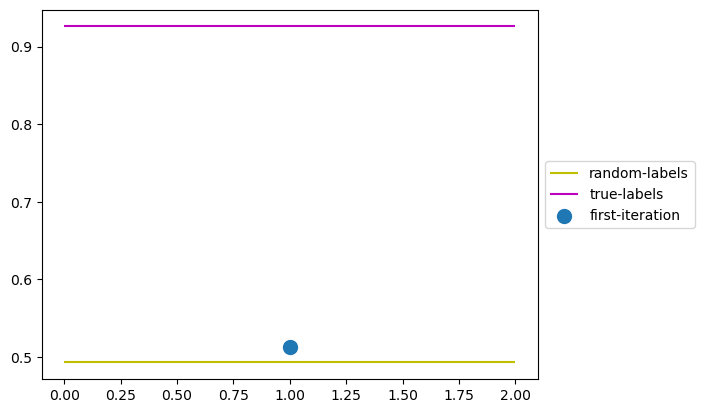

In [18]:
def plot_accuracies(accs=accs):
    colors = list("rgbcmy")
    items_num = len(accs)
    cont = 1

    for x, y in accs.items():
        if x in ['true-labels', 'random-labels', 'true-labels-best-clf']:
            plt.hlines(y, 0, (items_num-2)*2, colors=colors.pop())
        else:
            plt.scatter(cont, y, s=100)
            cont+=2
    plt.legend(accs.keys(), loc="center left",bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_accuracies()

This first iteration had an accuracy very close to random labeling, we should strive to do better than this. 

Before moving forward let's define `label_given_rules` function that performs all of steps you just saw, these are: 
- Apply rules to a dataframe of comments
- Cast resulting labels to a numpy array
- Delete all data points with NO_LABEL as label
- Calculate accuracy of model using automatic labels
- Save accuracy for plotting
- Print some useful metrics of process

In [19]:
def label_given_rules(df, rules_function, name, 
                      accs_dict=accs, verbose=True):
    
    # Apply labeling rules to comments
    labels = [rules_function(label) for label in df.text]
    
    # Convert to a numpy array
    labels = np.asarray(labels)
    
    # Save initial number of data points
    initial_size = labels.shape[0]
    
    # Trim points with NO_LABEL label
    X_train_al = df[labels != -1]
    labels = labels[labels != -1]
    
    # Save number of data points after trimming
    final_size = labels.shape[0]
    
    # Compute accuracy
    acc = calculate_accuracy(X_train_al, labels)
    
    # Print useful information
    if verbose:
        print(f"Proportion of data points kept: {final_size/initial_size*100:.2f}%\n")
        print(f"{name} labeling has an accuracy of {acc*100:.2f}%\n")
        
    # Save accuracy to accuracies dictionary
    accs_dict[name] = acc
    
    return X_train_al, labels, acc

Going forward we should come up with rules that have a better coverage of training data, thus making pattern discovery an easier task. Also notice how rules were only able to label as either SPAM or NO_LABEL, we should also create some rules that help identification of NOT_SPAM comments.

### Second iteration - Coming up with better rules

If you inspect comments in dataset you might be able to distinguish certain patterns at a glimpse. For example, not spam comments often make references to either number of views since these were most watched videos of 2015 or song in video and its contents . As for spam comments other common patterns are to promote gifts or ask to follow some channel or website.

Let's create some new rules that include these patterns:

In [20]:
def labeling_rules_2(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x
    ]
    
    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x
    ]
    
    # Classify depending on rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

This new set of rules looks more promising as it includes more patterns to classify as SPAM as well as some patterns to classify as NOT_SPAM. This should result in more data points with a label different to NO_LABEL.

Let's check if this is case.

Proportion of data points kept: 44.31%

second-iteration labeling has an accuracy of 73.21%



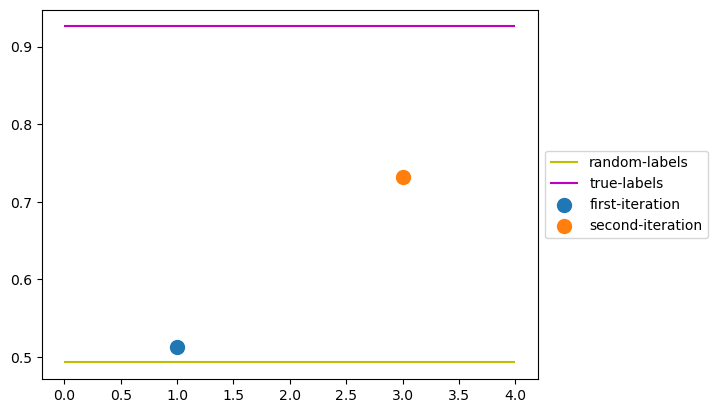

In [21]:
label_given_rules(X_train, labeling_rules_2, "second-iteration")

plot_accuracies()

This time 44% of original dataset was given a decisive label and there were data points for both labels, this helped model reach a higher accuracy when compared to first iteration. Now accuracy is considerably higher than random labeling but it is still very far away from upper bound.

Let's see if we can make it even better!

### Third Iteration - Even more rules

The rules we have defined so far are doing a fair job. Let's add two additional rules, one for classifying SPAM comments and other for opposite task.

At a glimpse it looks like NOT_SPAM comments are usually shorter. This may be due to them not including hyperlinks but also in general they tend to be more concrete such as "I love this song!".

Let's take a look at average number of characters for SPAM comments vs NOT_SPAM oned:

In [22]:
from statistics import mean

print(f"NOT_SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==0].text]):.2f} characters.")
print(f"SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==1].text]):.2f} characters.")

NOT_SPAM comments have an average of 49.64 characters.
SPAM comments have an average of 137.34 characters.


It sure looks like there is a big difference in number of characters for both types of comments.

To decide on a threshold to classify as NOT_SPAM let's plot a histogram of number of characters for NOT_SPAM comments:

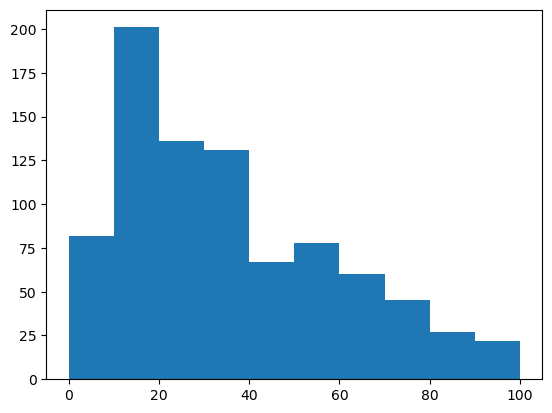

In [23]:
plt.hist([len(t) for t in df_labeled[df_labeled.label==0].text], range=(0,100))
plt.show()

The majority of NOT_SPAM comments have 30 or less characters so we'll use that as a threshold.

Another prevalent pattern in spam comments is to ask users to "check out" a channel, website or link.

Let's add these two new rules:

In [24]:
def labeling_rules_3(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x,
        len(x) < 30
    ]
    

    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x,
        "check out" in x
    ]
    
    # Classify depending on rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

Proportion of data points kept: 77.75%

third-iteration labeling has an accuracy of 90.05%



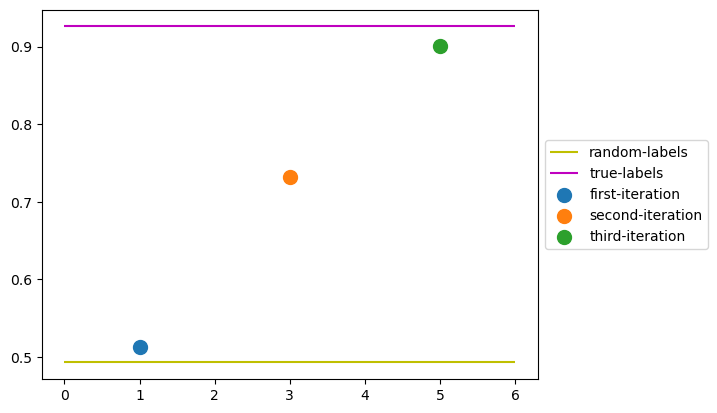

In [25]:
label_given_rules(X_train, labeling_rules_3, "third-iteration")

plot_accuracies()

These new rules do a pretty good job at both, covering dataset and having a good model accuracy. To be more concrete this labeling strategy reached an accuracy of ~86%! We are getting closer and closer to upper bound defined by using true labels.

We could keep going on adding more rules to improve accuracy and we do encourage you to try it out yourself!


### Come up with own rules

The following cells contain some code to help you inspect dataset for patterns and to test out these patterns. ones used before are commented out in case you want start from scratch or re-use them.

In [26]:
# Configure pandas to print out all rows to check complete dataset
pd.set_option('display.max_rows', None)

# Check NOT_SPAM comments
df_labeled[df_labeled.label==0]

,text,label
5,My honest opinion. It's a very mediocre song. ...,0
11,Rihanna and Eminem together are unstoppable.﻿,0
13,Anyone else notice that Megan Fox is in this v...,0
14,I love KATY PERRY &lt;3 &lt;3﻿,0
15,The best world cup song ever!!!!﻿,0
16,It was cool the best song ever ﻿,0
19,I like this song very much﻿,0
20,Best for partying ﻿,0
21,2 BILLION!!!﻿,0
22,OMG 2/7 People watched this video because ther...,0


In [27]:
# Check SPAM comments
df_labeled[df_labeled.label==1]

,text,label
0,Suscribe My Channel Please XD lol﻿,1
1,hey guy if you can please SUBSCRIBE to my chan...,1
2,Check out this video on YouTube:﻿,1
3,Check out this video on YouTube:﻿,1
4,"<a rel=""nofollow"" class=""ot-hashtag"" href=""htt...",1
6,marketglory . com/strategygame/andrijamatf ear...,1
7,We are an EDM apparel company dedicated to bri...,1
8,please read this please! i am a country singer...,1
9,http://thepiratebay.se/torrent/10626048/The.Ex...,1
10,Hi! I would appreciate it if you all could hel...,1


In [28]:
def your_labeling_rules(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define rules for classifying as NOT_SPAM
    not_spam_rules = [
#         "view" in x,
#         "song" in x,
#         len(x) < 30
    ]
    

    # Define rules for classifying as SPAM
    spam_rules = [
#         "free" in x,
#         "subs" in x,
#         "gift" in x,
#         "follow" in x,
#         "http" in x,
#         "check out" in x
    ]
    
    # Classify depending on rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1


try:
    label_given_rules(X_train, your_labeling_rules, "your-iteration")
    plot_accuracies()
    
except ValueError:
    print("You have not defined any rules.")

You have not defined any rules.


**the better labels are, better models will be**. Also it is important to realize that process of correctly labeling data is a very complex one. **Remember, you can think of each one of iterations of automatic labeling process to be a different labeler with different criteria for labeling**. If you assume you are hiring labelers you will want to hire latter for sure! 

Establishing baselines to compare against is really important as they provide perspective on how well data and models are performing.